# Python Technical Challenge

## _Searching an algorithm that sorts words from left to right line by line_

c: Dominic Catana <catanadominic@gmail.com>

In [266]:
# -----------------ONLY METHODS AND IMPORTS------------------------
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import scipy.spatial.distance as distance
import random

def add_id(data):
    k = 0
    for i in data:
        i['id'] = k
        k+=1
    return data

def extract_points(ocr_dataset):
    list_of_coords = []
    for it in ocr_dataset:
        for y in it['points']:
            list_of_coords.append(y)
    return list_of_coords

def get_ocr_data(path):
    f = open(path,)
    data = json.load(f)['ocr'];
    return data

def change_points_to_coords(ocr_dataset):
    l = []
    c = 0;
    x = -1;
    y = -1;
    min = 100000
    max = 0
    for c in ocr_dataset:
        x = c["points"][3][0]
        y = c["points"][3][1]
        w = c["points"][1][0]-c["points"][0][0]
        h = c["points"][2][1]-c["points"][1][1]
        c["points"]=[x,y,w,h]
    return ocr_dataset

def useful_data(coords):
    values = []
    original_list = []
    for i in coords:
        values.append(i['text'])
        values.append(i['points'][0])
        values.append(i['points'][2])   # take only the text and the opposite corners (left bottom, right top)
        original_list.append(values)
        values = []
    return original_list

def get_coords_sum(coords):
    values = []
    original_list = []
    for i in coords:
        values.append(i['text'])
        values.append(i['points'][0])
        values.append(i['points'][0][0]+i['points'][0][1])   # take text, sum of coordinates first point and top right corner's y
        values.append(i['points'][2][1])                   
        original_list.append(values)
        values = []
    return original_list 

def get_coords(sum_coords):
    values = []
    for i in sum_coords:
        values.append(i[1])   # take coordinates of left bottom from sum coords list
    return values 

def get_image_path(path_json):
    x = path_json.split(".")[0]
    return x+".jpg"

def random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
def draw_rect_text(image, color, text, x, y, w, h):
    image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
    cv2.putText(image, text, (x, y-3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.4, color, 1)
    

def sorting_algorithm(coords, path):
    coords = add_id(coords)
    initial_coords = useful_data(coords)
    sum_coords = get_coords_sum(coords)
    x_and_y = get_coords(sum_coords)
    sorted_list = []
    word_counter = 0
    k = 0
    img = cv2.imread(path)   # read image
    while k==0:
        try:
            line = []   # for each line we take a sorted text array/list
            rand_color = random_color()
            
            ymin = 100000
            for i in enumerate(sum_coords):
                if i[1][1][1] < ymin:
                    ymin = i[1][1][1]
                                            #take the highest rectangle point
            for i in enumerate(sum_coords):
                if ymin == i[1][1][1]:
                    init_val = i
                    
            threshold = abs(init_val[1][1][1] - init_val[1][3])  # separation lines limit

            start_line = [init_val[1][1]]    #start point of each line top to bottom
            
            x = list(map(lambda x:[x,abs(x[1]-init_val[1][1][1])],x_and_y))  #create list from remained coordinates with diff between points and initial val     
            
            l = []
            for count,i in enumerate(x):
                l.append([count,i])   
            x = l
            l = []
            for i in x:
                if i[1][1]<threshold:   # if word does not touch the limit between lines it enters on the row
                    l.append(i)
                    
             
            x_sorted = list(map(lambda x:[x[0],x[1][0]], sorted(l,key=lambda x:x[1][1])))    #sorting on row (from left to right)
            
            end_line = []
            points_index = []    # index of every word
            for x_temp in x_sorted:      # temp 
                points_index.append(x_temp[0])   #  counts the words from each line
                end_line.append(x_temp[1])   #  add last element in the line computed by distance
            dist = distance.cdist(start_line,end_line)[0]   
            
            d_index = [i for i in sorted(zip(dist,points_index), key=lambda x:x[0])]
            line.append(init_val[1][0])
            
            line_of_index = []
            boo = True
            for j in d_index:
                line.append(sum_coords[j[1]][0])
                word_counter+=1
                if len(line)==2 and boo:
                    line.pop()
                    boo = False
                line_of_index.append(j[1])
            
            #line = sorted(line, key=lambda x: x['points'][0][0])
            lines_of_points = []
            for i in line_of_index:
             #   print(i)
                for j in coords:
                    if j['id']==i:
                        lines_of_points.append(j)
                        draw_rect_text(img, rand_color, j['text'], int(j['points'][0][0]), int(j['points'][0][1]), int(j['points'][1][0]-j['points'][0][0]), int(j['points'][3][1]-j['points'][0][1]))
                        
            lines_of_points = sorted(lines_of_points, key=lambda x: x['points'][0][0])       # sort points at this line after left buttom xcoord     
            line_values = []
            for d in lines_of_points:
                line_values.append(d['text'])
            
      #      draw_rect_text(img, rand_color, 'gfdsfg', 100, 100, 50, 50)                 
            for n in sorted(line_of_index, reverse=True):  # delete the marked words on the line
                del sum_coords[n]
                del x_and_y[n]    
            sorted_list.append(line_values)   # add line to the final list
        except Exception as e:
            k = 1
            
            
    plt.figure(figsize = (50,15))
    plt.imshow(img, )       
      
    return sorted_list
    



[['1734-N', 'STREET,', 'N.', 'W.'], ['Complete', 'American', 'Dinners'], ['Appelizers'], ['Fruit', 'Cop.', 'Supreme', 'Tomato', 'or', 'Grapefruit', 'Juice'], ['Vegetable', '(V-8)', 'Cocktail'], ['Soup', 'du', 'Jour', 'Choice', 'of', 'Soup', 'or', 'Appotizer)'], ['Entress'], ['Breast', 'of', 'Chicken', 'Baked', 'in', 'Cream', '3.00'], ['Farm', 'Fresh', 'Half', 'Spring', 'Chicken', '2.75'], ['Broiled', 'or', 'Pan', 'Fried:'], ['Home', 'Baked', 'Ham-a', 'with', 'Pineapple', 'Ring', '2.75'], ['Broiled', 'Strip', 'Sirloin', 'steak', '(Charcoal)', '12 ox', '4.50'], ['Choice', 'Cut'], ['Roast', 'Prime', 'Ribs', 'of', 'Beef,', 'Jus.', '3.75'], ['French', 'Fried', 'Shrimp-', 'with', 'Tartar', 'Sauce', '2.75'], ['Above', 'served', 'with', 'Baked', 'Potatoes,', 'Vegetable', 'and', 'Mixed', 'Green'], ['Salad,', 'home', 'baked', 'biscuits', 'and', 'our', 'famous', 'delicious', 'butter-scotch'], ['rolls'], ['Dowerls'], ['Deep', 'Dish', 'Apple', 'Pie', 'Ice', 'Cream'], ['Peach', 'Melba'], ['Coffee', 

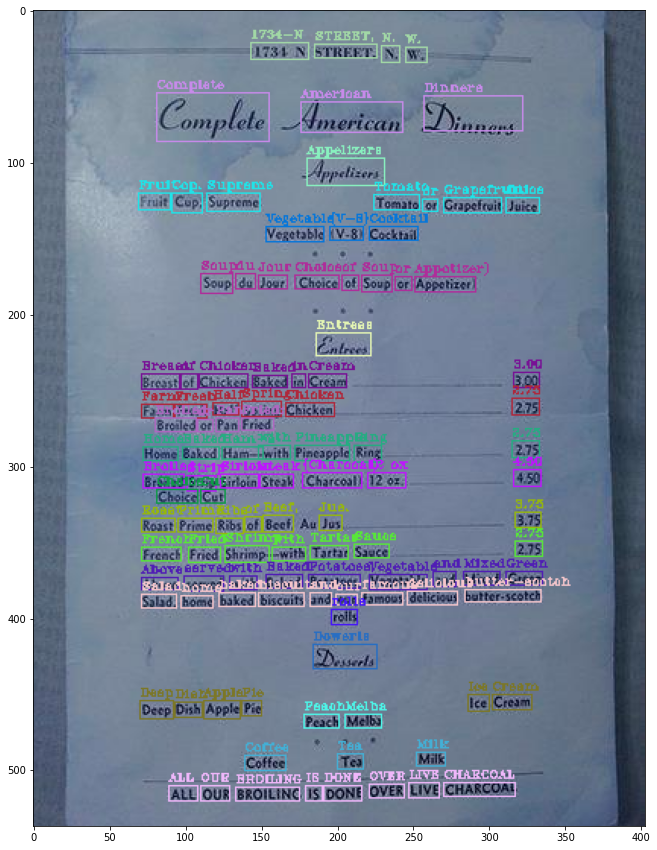

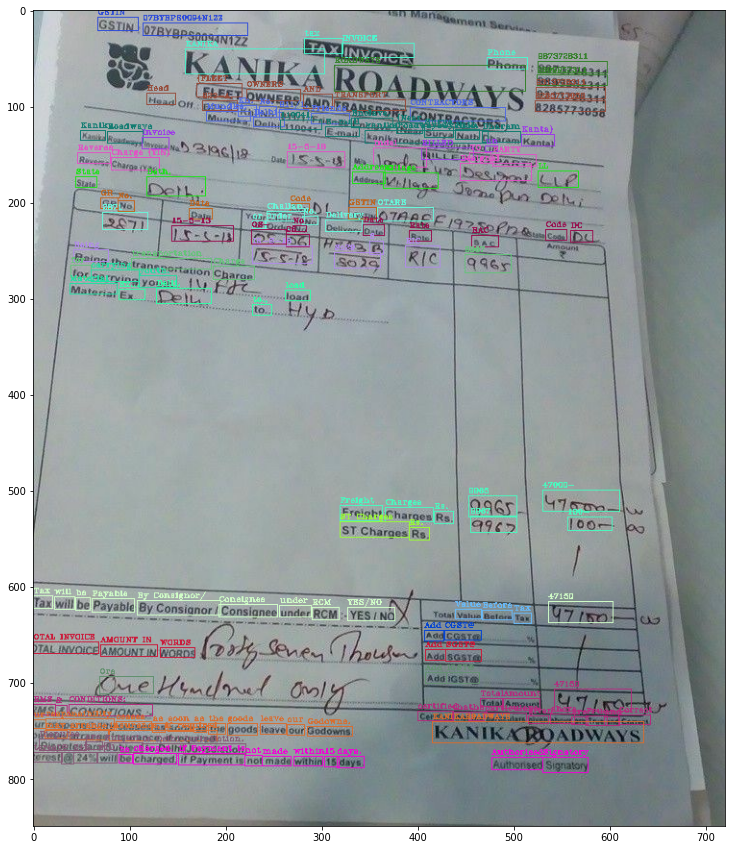

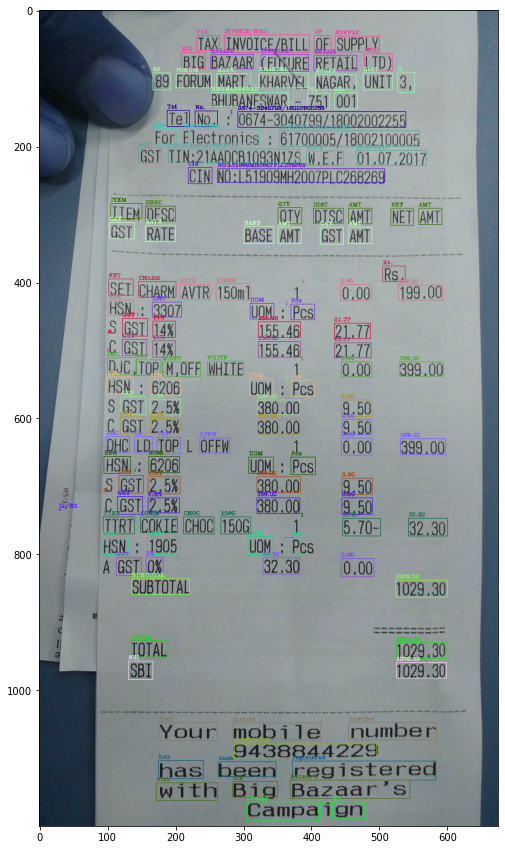

In [267]:
# --------------__main__--------------------
import time

start = time.time()

paths = ["datasets/menu2.json","datasets/40.json","datasets/18.json"]
for i in paths:
    data = get_ocr_data(i)
    print(sorting_algorithm(data, get_image_path(i)))

end = time.time()
print(end - start, "s.")



